In [1]:
# pip install numpy
import numpy as np

# pip install pandas
import pandas as pd

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries

# pip install ta
from ta import momentum as mo
from ta import volume as vo
from ta import trend as tr

In [2]:
config = {
    "alpha_vantage": {
        "key": "65U394ZVSII3IL5P", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "msft",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.95,
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 14, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points: 5471 from 2000-01-12 to 2021-10-08


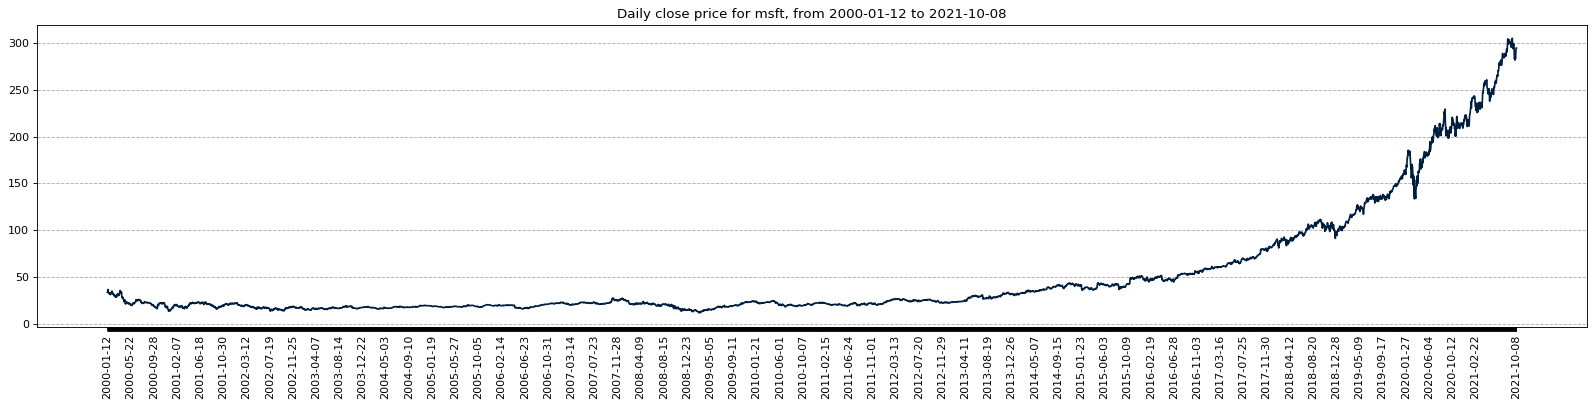

In [3]:
def calculate_technical_analysis(data_close_price):
    rsi = mo.rsi(pd.Series(data_close_price))
    stochrsi = mo.stochrsi(pd.Series(data_close_price))
    stochrsi_d = mo.stochrsi_d(pd.Series(data_close_price))
    stochrsi_k = mo.stochrsi_k(pd.Series(data_close_price))

    tsi = mo.tsi(pd.Series(data_close_price))
    tsi_signal = tr.ema_indicator(tsi, window=13)

    macd = tr.macd(pd.Series(data_close_price))
    macd_diff = tr.macd_diff(pd.Series(data_close_price))
    macd_signal = tr.macd_signal(pd.Series(data_close_price))

    ema_w8 = tr.ema_indicator(pd.Series(data_close_price), window=8)
    ema_w20 = tr.ema_indicator(pd.Series(data_close_price), window=20)

    sma_w13 = tr.sma_indicator(pd.Series(data_close_price), window=13)
    sma_w25 = tr.sma_indicator(pd.Series(data_close_price), window=25)

    return pd.DataFrame({
        '0': data_close_price[50::],
        '1': rsi.values[50::],
        '2': stochrsi.values[50::],
        '3': stochrsi_d.values[50::],
        '4': stochrsi_k.values[50::],
        '5': tsi.values[50::],
        '6': tsi_signal.values[50::],
        '7': macd.values[50::],
        '8': macd_diff.values[50::],
        '9': macd_signal.values[50::],
        '10': ema_w8.values[50::],
        '11': ema_w20.values[50::],
        '12': sma_w13.values[50::],
        '13': sma_w25.values[50::]
    }).values

def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()][:-50]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    data = calculate_technical_analysis(data_close_price)

    roc = mo.roc(pd.Series(data_close_price), window=1).values[50::]

    num_data_points = data.shape[0]
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, pd.DataFrame(data).iloc[:,0].values, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data, num_data_points, roc

data_date, data, num_data_points, roc = download_data(config, plot=config["plots"]["show_plots"])

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x, column=False, index=0):
        if column:
            return (x*self.sd[0][index]) + self.mu[0][index]

        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data = scaler.fit_transform(data)

pd.DataFrame(normalized_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.287780,-0.721953,-1.433100,-1.437107,-1.441114,0.731318,1.804625,0.399005,-1.514130,0.940064,-0.259624,-0.260660,-0.242067,-0.259703
1,-0.277089,-0.380383,-1.124591,-1.484428,-1.478959,0.537980,1.630748,0.273869,-1.526160,0.810263,-0.263239,-0.261909,-0.246761,-0.256203
2,-0.253357,0.264692,-0.421552,-1.401135,-1.103960,0.495263,1.475015,0.263416,-1.246175,0.704185,-0.260746,-0.260744,-0.248940,-0.251952
3,-0.237000,0.632161,-0.044807,-1.104445,-0.589296,0.534417,1.347666,0.313753,-0.868675,0.630093,-0.255152,-0.258107,-0.250032,-0.247278
4,-0.281419,-0.521995,-1.221542,-0.807092,-0.625237,0.306475,1.202784,0.170718,-1.054998,0.540214,-0.260728,-0.260018,-0.254440,-0.245015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466,3.921512,-1.290038,-0.960309,-1.339672,-1.065780,-1.056831,-0.247283,-2.621714,-5.364325,-0.986759,4.034591,4.155240,4.129797,4.237844
5467,4.016803,-0.665508,-0.353301,-1.025659,-0.665479,-1.009316,-0.370543,-2.559594,-4.133438,-1.337481,4.036337,4.148800,4.108240,4.227644
5468,4.090169,-0.249980,0.846867,-0.662651,-0.172533,-0.879833,-0.455901,-2.194695,-2.384127,-1.539980,4.054091,4.150069,4.099387,4.221611
5469,4.119516,-0.093064,1.149438,-0.079117,0.609587,-0.748170,-0.508429,-1.770877,-0.835891,-1.611293,4.074459,4.154057,4.100108,4.216810


In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size,x.shape[1]), strides=(x.strides[0],x.strides[0],x.strides[1]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    output = np.array([1 if n > 0 else 0 for n in roc])

    # use the next day as label
    # output = pd.DataFrame(x).iloc[window_size:,0].values
    return output

def prepare_data(data, config):
    data_x, data_x_unseen = prepare_data_x(data, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(data, window_size=config["data"]["window_size"])

    # split dataset
    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data, config)

print(split_index)
print(data_x_train.shape)
print(data_x_val.shape)
print(data_y_train.shape)


5197
(5197, 20, 14)
(254, 20, 14)
[0 1 1 ... 0 0 0]


In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # x = np.expand_dims(x, 2) # if we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (5197, 20, 14) (5197,)
Validation data shape (254, 20, 14) (274,)


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [8]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/200] | loss train:0.351940, test:0.015625 | lr:0.010000
Epoch[2/200] | loss train:0.335052, test:0.015875 | lr:0.010000
Epoch[3/200] | loss train:0.334595, test:0.016281 | lr:0.010000
Epoch[4/200] | loss train:0.333532, test:0.016008 | lr:0.010000
Epoch[5/200] | loss train:0.331444, test:0.015532 | lr:0.010000
Epoch[6/200] | loss train:0.329211, test:0.015549 | lr:0.010000
Epoch[7/200] | loss train:0.330608, test:0.015972 | lr:0.010000
Epoch[8/200] | loss train:0.329418, test:0.015784 | lr:0.010000
Epoch[9/200] | loss train:0.329577, test:0.015686 | lr:0.010000
Epoch[10/200] | loss train:0.330675, test:0.015632 | lr:0.010000
Epoch[11/200] | loss train:0.327576, test:0.015926 | lr:0.010000
Epoch[12/200] | loss train:0.328454, test:0.016731 | lr:0.010000
Epoch[13/200] | loss train:0.328557, test:0.015530 | lr:0.010000
Epoch[14/200] | loss train:0.317014, test:0.015922 | lr:0.010000
Epoch[15/200] | loss train:0.270272, test:0.015443 | lr:0.010000
Epoch[16/200] | loss train:0.22253

In [14]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))
print(predicted_val)
if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train, column=True, index=0)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val, column=True, index=0)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    

[ 1.09204483  0.03899947  0.04858676  0.02680472  0.84730995  0.03998402
  0.0407545   0.02645215  0.03668037  0.0547677   0.02077007  0.77542591
  0.99144351  0.97191751  0.03345835  0.93642437  1.00363934 -0.04404202
  0.7557869  -0.07966706  0.83936536  0.91260183  1.01987636  0.91597319
  1.01065695  0.03110322  0.04996744  0.11375359  0.04556665  1.18009353
  1.00468934  0.96137613  1.16383922  0.02266544  0.00944787  0.01947281
  0.05279174  0.01181421  0.11815533  0.89483798  1.02331376  1.0438652
  0.85955453  0.00242198  0.06130588  1.0019815   0.39604211  0.0318341
  0.04647455  0.07934162  0.26069131  0.83859789  0.03187439  0.01685879
  0.85362482  0.33784267  0.597821    0.03785598  0.98304975  0.02146944
  0.02583763  0.68830127  0.57735288  0.96452415 -0.06448177 -0.00830492
  0.99087095  1.00358927  0.41407049  0.97421503  0.98955452  0.04419908
  0.88134122  0.83541536  0.04516897  0.87228197  0.97479916  0.03744325
  0.0549632   0.29153687  0.02265126  0.02410164  0.0